### Todo 

0. DONE get plotting of various functions set up and also filtering down to just atm vols
1. DONE get ns fit working
2. DONE pull in earnings history for the relevant date  (top 150)
3. DONE add ignore front week for ns fitting 
3. calculate fwd vols (for fitting via optimization)
4. fits model to flat in fwd space  
5. strip earnings 
6. strip term structure 
5. calculate final schema 
6. store for every day 

In [2]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import warnings
import numpy as np
from scipy.optimize import curve_fit
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import altair as alt


warnings.filterwarnings('ignore')  # Suppress all warnings


# Set the option to display all columns
pd.set_option('display.max_columns', None)

def run_query(query, credentials_path):
    """Sends a custom query to BigQuery using a specified credentials file."""
    try:
        credentials = service_account.Credentials.from_service_account_file(credentials_path)
        client = bigquery.Client(credentials=credentials)

        query_job = client.query(query)
        results = query_job.result()
        # Convert RowIterator to DataFrame
        df = results.to_dataframe()

        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None


ModuleNotFoundError: No module named 'google'

In [15]:
# Example usage
query_string = """
    SELECT
        *
    FROM
        `trading-house-1.trading_house_options_all_1.options_all_table`
    WHERE trade_date = DATE(2025, 1, 28);
"""

credentials_file_path = "trading-house-1-master.json"  # Replace with your credentials file path

base_df = run_query(query_string, credentials_file_path)
base_df.sort_values("ticker", inplace=True);

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [ ]:
base_df 

In [ ]:
spy_base_df = base_df.query("ticker == 'SPY'").copy().reset_index().drop(columns=["index"])
grouped_spy_base_df = spy_base_df.groupby(['ticker', 'expirDate'])

### pull in earnings history for the relevant date
earnings_data_points = {
    "Implied Earnings Move Calculation": [
        "orIvXern20d",  # Constant Maturity Ex-Earnings IV (short-term)
        "orIvXernInf",  # Constant Maturity Ex-Earnings IV (long-term/asymptotic)
        "atmIvM1"       # At-the-money IV for the first month
        # Potentially: Other IV surface parameters (slope, deriv) if needed for detailed modeling
    ],
    "Implied Earnings Effects Calculation": [
        "impliedEe",   # Implied Earnings Effect
        "ernMv1",      # Earnings Move (1 month)
        "ernMv2",      # Earnings Move (2 months)
        "orFcst20d",   # ORATS Forecasted IV (20 day)
        "orIvFcst20d",  # ORATS Implied IV Forecast (20 day)
        "orFcstInf"    # ORATS Forecasted IV (long-term)
    ],
    "General Earnings Analysis": [
        "ernDate1",    # Earnings Date 1
        "ernDate2",    # Earnings Date 2
        "ernDate3",    # Earnings Date 3
        "ernDate12",   # Earnings Date 12
        "ernEffct1",   # Earnings Effect
        "absAvgErnMv"  # Average Absolute Earnings Move
    ]
}

# Create a comma-separated string for each category
comma_separated_lists = {}
for category, data_points in earnings_data_points.items():
    comma_separated_lists[category] = ", ".join(f'"{dp}"' for dp in data_points)

# Print the results
for category, data_points_string in comma_separated_lists.items():
    print(f"{category}:\n{data_points_string}\n")


# If you want one big list (less organized):
all_earnings_data_points = []
for data_points in earnings_data_points.values():
    all_earnings_data_points.extend(data_points)

all_earnings_data_points_string = ", ".join(f'"{dp}"' for dp in all_earnings_data_points)
print("All Earnings Data Points:\n", all_earnings_data_points_string)

Implied Earnings Move Calculation:
"orIvXern20d", "orIvXernInf", "atmIvM1"

Implied Earnings Effects Calculation:
"impliedEe", "ernMv1", "ernMv2", "orFcst20d", "orIvFcst20d", "orFcstInf"

General Earnings Analysis:
"ernDate1", "ernDate2", "ernDate3", "ernDate12", "ernEffct1", "absAvgErnMv"

All Earnings Data Points:
 "orIvXern20d", "orIvXernInf", "atmIvM1", "impliedEe", "ernMv1", "ernMv2", "orFcst20d", "orIvFcst20d", "orFcstInf", "ernDate1", "ernDate2", "ernDate3", "ernDate12", "ernEffct1", "absAvgErnMv"


In [ ]:
import requests
import pandas as pd
import numpy as np
import json
import os 

options_url = "https://api.orats.io/datav2/hist/strikes"
cores_url = "https://api.orats.io/datav2/hist/cores"
earns_url = "https://api.orats.io/datav2/hist/earnings"

token = "df44ef7f-80ab-4508-924c-0e6d199723fc"
tickers = pd.read_csv("tickers.csv")[["Symbol", "Weight"]]
pd.set_option('display.max_columns', None)


request_list = []

for i in range(0, 50):
    request_list += [list(tickers.Symbol[(i * 10):(i * 10 + 10)])]
    
top_150 = request_list[0:15]
querystrings = []
for check in top_150:
    querystring = {"token":token, "ticker": ",".join(check), "tradeDate":"2025-01-28"}
    querystrings += [querystring]
    
df_list = []
# for qs in querystrings:
#     response = requests.request("GET", earns_url, params=qs)
#     df = pd.json_normalize(response.json()["data"])
#     df['earnDate'] = pd.to_datetime(df['earnDate'])
#     df['earnDateShifted'] = df['earnDate']  + pd.offsets.BusinessDay(1)
#     df['anncTod'] = df['anncTod'].astype(int)
#     df['earnDateEff'] = np.where(df['anncTod'] > 1600, df['earnDateShifted'], df['earnDate'])
#     df_list += [df]

for qs in querystrings:
    response = requests.request("GET", cores_url, params=qs)
    df = pd.json_normalize(response.json()["data"])
    # df['earnDate'] = pd.to_datetime(df['earnDate'])
    # df['earnDateShifted'] = df['earnDate']  + pd.offsets.BusinessDay(1)
    # df['anncTod'] = df['anncTod'].astype(int)
    # df['earnDateEff'] = np.where(df['anncTod'] > 1600, df['earnDateShifted'], df['earnDate'])
    df_list += [df]

    all_earnings_df = pd.concat(df_list)

In [183]:
all_earnings_df = pd.concat(df_list)

In [184]:
all_earnings_df

,ticker,tradeDate,assetType,priorCls,pxAtmIv,mktCap,cVolu,cOi,pVolu,pOi,orFcst20d,orIvFcst20d,orFcstInf,orIvXern20d,orIvXernInf,iv200Ma,atmIvM1,atmFitIvM1,atmFcstIvM1,dtExM1,atmIvM2,atmFitIvM2,atmFcstIvM2,dtExM2,atmIvM3,atmFitIvM3,atmFcstIvM3,dtExM3,atmIvM4,atmFitIvM4,atmFcstIvM4,dtExM4,iRate5wk,iRateLt,px1kGam,volOfVol,volOfIvol,slope,slopeInf,slopeFcst,slopeFcstInf,deriv,derivInf,derivFcst,derivFcstInf,mktWidthVol,mktWidthVolInf,cAddPrem,pAddPrem,rip,ivEarnReturn,fcstR2,fcstR2Imp,hiHedge,loHedge,stkVolu,avgOptVolu20d,sector,orHv1d,orHv5d,orHv10d,orHv20d,orHv60d,orHv90d,orHv120d,orHv252d,orHv500d,orHv1000d,clsHv5d,clsHv10d,clsHv20d,clsHv60d,clsHv90d,clsHv120d,clsHv252d,clsHv500d,clsHv1000d,iv20d,iv30d,iv60d,iv90d,iv6m,clsPx1w,stkPxChng1wk,clsPx1m,stkPxChng1m,clsPx6m,stkPxChng6m,clsPx1y,stkPxChng1y,divFreq,divYield,divGrwth,divDate,divAmt,nextErn,nextErnTod,lastErn,lastErnTod,absAvgErnMv,impliedIee,daysToNextErn,tkOver,etfIncl,bestEtf,sectorName,correlSpy1m,correlSpy1y,correlEtf1m,correlEtf1y,beta1m,beta1y,ivPctile1m,ivPctile1y,ivPctileSpy,ivPctileEtf,ivStdvMean,ivStdv1y,ivSpyRatio,ivSpyRatioAvg1m,ivSpyRatioAvg1y,ivSpyRatioStdv1y,ivEtfRatio,ivEtfRatioAvg1m,ivEtfRatioAvg1y,ivEtFratioStdv1y,ivHvXernRatio,ivHvXernRatio1m,ivHvXernRatio1y,ivHvXernRatioStdv1y,etfIvHvXernRatio,etfIvHvXernRatio1m,etfIvHvXernRatio1y,etfIvHvXernRatioStdv1y,slopepctile,slopeavg1m,slopeavg1y,slopeStdv1y,etfSlopeRatio,etfSlopeRatioAvg1m,etfSlopeRatioAvg1y,etfSlopeRatioAvgStdv1y,impliedR2,contango,nextDiv,impliedNextDiv,annActDiv,annIdiv,borrow30,borrow2yr,error,confidence,pxCls,wksNextErn,ernMnth,oi,straPxM1,straPxM2,smoothStraPxM1,smoothStrPxM2,fcstStraPxM1,fcstStraPxM2,loStrikeM1,hiStrikeM1,loStrikeM2,hiStrikeM2,ernDate1,ernDate2,ernDate3,ernDate4,ernDate5,ernDate6,ernDate7,ernDate8,ernDate9,ernDate10,ernDate11,ernDate12,ernMv1,ernMv2,ernMv3,ernMv4,ernMv5,ernMv6,ernMv7,ernMv8,ernMv9,ernMv10,ernMv11,ernMv12,ernStraPct1,ernStraPct2,ernStraPct3,ernStraPct4,ernStraPct5,ernStraPct6,ernStraPct7,ernStraPct8,ernStraPct9,ernStraPct10,ernStraPct11,ernStraPct12,ernEffct1,ernEffct2,ernEffct3,ernEffct4,ernEffct5,ernEffct6,ernEffct7,ernEffct8,ernEffct9,ernEffct10,ernEffct11,ernEffct12,orHvXern5d,orHvXern10d,orHvXern20d,orHvXern60d,orHvXern90d,orHvXern120d,orHvXern252d,orHvXern500d,orHvXern1000d,clsHvXern5d,clsHvXern10d,clsHvXern20d,clsHvXern60d,clsHvXern90d,clsHvXern120d,clsHvXern252d,clsHvXern500d,clsHvXern1000d,iv10d,iv1yr,fcstSlope,fcstErnEffct,ernMvStdv,impliedEe,impErnMv,impMth2ErnMv,fairVol90d,fairXieeVol90d,fairMth2XieeVol90d,impErnMv90d,impErnMvMth290d,exErnIv10d,exErnIv20d,exErnIv30d,exErnIv60d,exErnIv90d,exErnIv6m,exErnIv1yr,dlt5Iv10d,dlt5Iv20d,dlt5Iv30d,dlt5Iv60d,dlt5Iv90d,dlt5Iv6m,dlt5Iv1y,exErnDlt5Iv10d,exErnDlt5Iv20d,exErnDlt5Iv30d,exErnDlt5Iv60d,exErnDlt5Iv90d,exErnDlt5Iv6m,exErnDlt5Iv1y,dlt25Iv10d,dlt25Iv20d,dlt25Iv30d,dlt25Iv60d,dlt25Iv90d,dlt25Iv6m,dlt25Iv1y,exErnDlt25Iv10d,exErnDlt25Iv20d,exErnDlt25Iv30d,exErnDlt25Iv60d,exErnDlt25Iv90d,exErnDlt25Iv6m,exErnDlt25Iv1y,dlt75Iv10d,dlt75Iv20d,dlt75Iv30d,dlt75Iv60d,dlt75Iv90d,dlt75Iv6m,dlt75Iv1y,exErnDlt75Iv10d,exErnDlt75Iv20d,exErnDlt75Iv30d,exErnDlt75Iv60d,exErnDlt75Iv90d,exErnDlt75Iv6m,exErnDlt75Iv1y,dlt95Iv10d,dlt95Iv20d,dlt95Iv30d,dlt95Iv60d,dlt95Iv90d,dlt95Iv6m,dlt95Iv1y,exErnDlt95Iv10d,exErnDlt95Iv20d,exErnDlt95Iv30d,exErnDlt95Iv60d,exErnDlt95Iv90d,exErnDlt95Iv6m,exErnDlt95Iv1y,fwd30_20,fwd60_30,fwd90_60,fwd180_90,fwd90_30,fexErn30_20,fexErn60_30,fexErn90_60,fexErn180_90,fexErn90_30,ffwd30_20,ffwd60_30,ffwd90_60,ffwd180_90,ffwd90_30,ffexErn30_20,ffexErn60_30,ffexErn90_60,ffexErn180_90,ffexErn90_30,fbfwd30_20,fbfwd60_30,fbfwd90_60,fbfwd180_90,fbfwd90_30,fbfexErn30_20,fbfexErn60_30,fbfexErn90_60,fbfexErn180_90,fbfexErn90_30,impliedEarningsMove,updatedAt
0,AAPL,2025-01-28,3,229.86,238.80,3591051,623805,2423355,404048,1873177,25.5147,24.9616,21.01,22.54,19.27,20.64,30.4349,30.6356,27.7426,25,25.5532,25.7148,25.4642,53,24.2781,23.9904,24.5072,80,24.5991,24.6894,24.3146,109,4.37,4.18,5411.39,0.0582,0.0571

In [185]:
# all_earnings_data_points

In [72]:
def filter_expir_dates_per_ticker(df, date_column='expirDate', min_days=7, max_days=60, ticker_column='ticker'):
    """
    Filters a DataFrame to include only the expirDate which best fits the criteria per ticker.

    Args:
        df (pd.DataFrame): The DataFrame to filter.
        date_column (str): The name of the datetime column containing expirDates.
        min_days (int): The minimum number of days away from today.
        max_days (int): The maximum number of days away from today.
        ticker_column (str): The name of the ticker column.

    Returns:
        pd.DataFrame: A new DataFrame with the best fitting expirDate per ticker.
    """

    today = datetime.date.today()
    min_date = today + datetime.timedelta(days=min_days)
    max_date = today + datetime.timedelta(days=max_days)
    df[date_column] = pd.to_datetime(df[date_column])

    filtered_df = df[(df[date_column].dt.date > min_date) & (df[date_column].dt.date < max_date)].copy()

    def get_best_expir_date(group):
        if group.empty:
            return pd.DataFrame()  # Return empty DataFrame if group is empty

        first_expir_date = group[date_column].min()
        return group[group[date_column] == first_expir_date]

    filtered_best_expir_per_ticker = filtered_df.groupby(ticker_column).apply(get_best_expir_date).reset_index(drop=True)

    return filtered_best_expir_per_ticker

# Example usage (assuming your DataFrame is named base_df)
# Replace base_df with your actual DataFrame name
# and if your date column is not named 'expirDate' change that as well.
filtered_data = filter_expir_dates_per_ticker(base_df)

filtered_data

,ticker,cOpra,pOpra,stkPx,expirDate,yte,strike,cVolu,cOi,pVolu,pOi,cBidPx,cValue,cAskPx,pBidPx,pValue,pAskPx,cBidIv,cMidIv,cAskIv,smoothSmvVol,pBidIv,pMidIv,pAskIv,iRate,divRate,residualRateData,delta,gamma,theta,vega,rho,phi,driftlessTheta,extVol,extCTheo,extPTheo,spot_px,trade_date
0,A,A250417C00100000,A250417P00100000,150.86,2025-04-17,0.21644,100.0,0.0,0.0,0.0,0.0,50.00,51.58,53.80,0.00,0.03,1.00,0.0,0.37035,0.740697,0.354330,0.000000,0.30075,0.601507,0.0432,0.0,0.000000,0.994244,0.000491,-0.010470,0.007694,0.212914,-0.324503,-0.001921,0.352028,51.835804,0.030613,0.0,2025-01-28
1,A,A250417C00120000,A250417P00120000,150.86,2025-04-17,0.21644,120.0,0.0,0.0,0.0,0.0,31.70,32.74,34.30,0.05,0.71,1.80,0.0,0.24379,0.487586,0.353088,0.223602,0.33813,0.452653,0.0432,0.0,-0.012016,0.936950,0.004912,-0.032603,0.091321,0.234962,-0.305803,-0.019066,0.351397,32.732445,0.695072,0.0,2025-01-28
2,A,A250417C00125000,A250417P00125000,150.86,2025-04-17,0.21644,125.0,0.0,0.0,0.0,0.0,27.00,28.01,29.70,0.55,0.93,2.05,0.0,0.22483,0.449655,0.325669,0.286568,0.34934,0.412112,0.0432,0.0,-0.011745,0.915738,0.006684,-0.035828,0.106565,0.238277,-0.298880,-0.022070,0.334323,28.105024,1.022043,0.0,2025-01-28
3,A,A250417C00185000,A250417P00185000,150.86,2025-04-17,0.21644,185.0,0.0,3.0,0.0,0.0,0.00,0.22,0.75,32.20,34.14,35.10,0.0,0.14639,0.292785,0.227641,0.000000,0.18733,0.374663,0.0432,0.0,0.000000,0.035212,0.004861,-0.008347,0.052928,0.011025,-0.011493,-0.007841,0.262400,0.465096,34.139999,0.0,2025-01-28
4,A,A250417C00080000,A250417P00080000,150.86,2025-04-17,0.21644,80.0,0.0,0.0,0.0,0.0,69.90,71.36,73.60,0.00,0.00,1.35,0.0,0.52149,1.042986,0.362052,0.000000,0.46064,0.921275,0.0432,0.0,0.000000,0.998344,0.000007,-0.000247,0.000143,0.171457,-0.325841,-0.000028,0.357603,71.568726,0.000181,0.0,2025-01-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71235,ZZZ,ZZZ250516C00020600,ZZZ250516P00020600,28.16,2025-05-16,0.29589,20.6,0.0,0.0,0.0,0.0,6.40,7.83,9.40,0.00,0.01,5.00,0.0,0.42911,0.858217,0.251590,0.000000,0.82297,1.645933,0.0425,0.0,0.000000,0.993003,0.005061,-0.002693,0.003339,0.059564,-0.082715,-0.000348,0.251084,7.826431,0.009168,0.0,2025-01-28
71236,ZZZ,ZZZ250516C00023600,ZZZ250516P00023600,28.16,2025-05-16,0.29589,23.6,0.0,0.0,0.0,0.0,3.70,4.98,6.70,0.00,0.13,5.00,0.0,0.34197,0.683937,0.248868,0.000000,0.65496,1.309918,0.0425,0.0,0.000000,0.928998,0.035739,-0.004871,0.019774,0.062647,-0.077384,-0.002405,0.248368,4.980958,0.127730,0.0,2025-01-28
71237,ZZZ,ZZZ250516C00030600,ZZZ250516P00030600,28.16,2025-05-16,0.29589,30.6,0.0,7.0,0.0,0.0,0.00,0.69,0.90,1.20,2.83,6.20,0.0,0.13731,0.274628,0.236133,0.000000,0.40291,0.805811,0.0425,0.0,0.000000,0.313455,0.098353,-0.006905,0.054376,0.024081,-0.026110,-0.005957,0.235659,0.683334,2.829463,0.0,2025-01-28
71238,ZZZ,ZZZ250516C00032600,ZZZ250516P00032600,28.16,2025-05-16,0.29589,32.6,0.0,0.0,0.0,0.0,0.00,0.29,0.95,3.00,4.50,8.00,0.0,0.18825,0.376506,0.234231,0.000000,0.44037,0.880741,0.0425,0.0,0.000000,0.161278,0.068332,-0.004568,0.037696,0.012577,-0.013434,-0.004073,0.233761,0.287862,4.502107,0.0,2025-01-28


In [252]:
import pandas as pd

def calculate_forward_volatility(df, strike_column='strike', stkpx_column='stkPx', expir_date_column='expirDate', vol_column='smoothSmvVol', new_col_name='forward_vol'):
    """
    Calculates forward volatilities for each ticker in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        strike_column (str): The name of the strike price column.
        stkpx_column (str): The name of the stock price column.
        expir_date_column (str): The name of the expiration date column.
        vol_column (str): The name of the volatility column.
        new_col_name (str): The name for the new forward volatility column.

    Returns:
        pd.DataFrame: The DataFrame with the added forward volatility column.
    """

    try:
        # Ensure expirDate is datetime
        df[expir_date_column] = pd.to_datetime(df[expir_date_column])

        def calculate_forward_vol(group):
            """Calculates the forward volatility for a group of options with the same expirDate."""

            # Sort by strike price
            group = group.sort_values(by=strike_column)

            forward_vols = []
            for i in range(len(group) - 1):
                # Get data for two adjacent strikes
                lower_strike_row = group.iloc[i]
                upper_strike_row = group.iloc[i + 1]

                # Extract relevant data
                lower_strike = lower_strike_row[strike_column]
                upper_strike = upper_strike_row[strike_column]
                lower_vol = lower_strike_row[vol_column]
                upper_vol = upper_strike_row[vol_column]

                # Calculate forward volatility (simplified linear interpolation)
                #  This is a simplified example; more sophisticated methods exist
                forward_vol = (lower_vol + upper_vol) / 2  # Simple average
                forward_vols.append(forward_vol)

            # Pad the forward volatility list to match the original group's length
            forward_vols.insert(0, forward_vols[0])  # Duplicate the first value
            if len(forward_vols) < len(group):
                forward_vols.extend([forward_vols[-1]] * (len(group) - len(forward_vols)))

            group[new_col_name] = forward_vols
            return group

        # Group by expirDate and apply the forward volatility calculation
        df = df.groupby(expir_date_column).apply(calculate_forward_vol)

        return df

    except KeyError as e:
        print(f"KeyError: Column '{e.args[0]}' not found in DataFrame.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

# Example Usage
# Assuming your DataFrame is named 'options_data'
# and you want to calculate the forward volatility using 'smoothSmvVol'
# and store it in a new column named 'forward_volatility'

forward_vol_df = calculate_forward_volatility(filtered_data)
forward_vol_df
# print(forward_vol_df[['expirDate', 'strike', 'smoothSmvVol', 'forward_volatility']])

KeyboardInterrupt: 

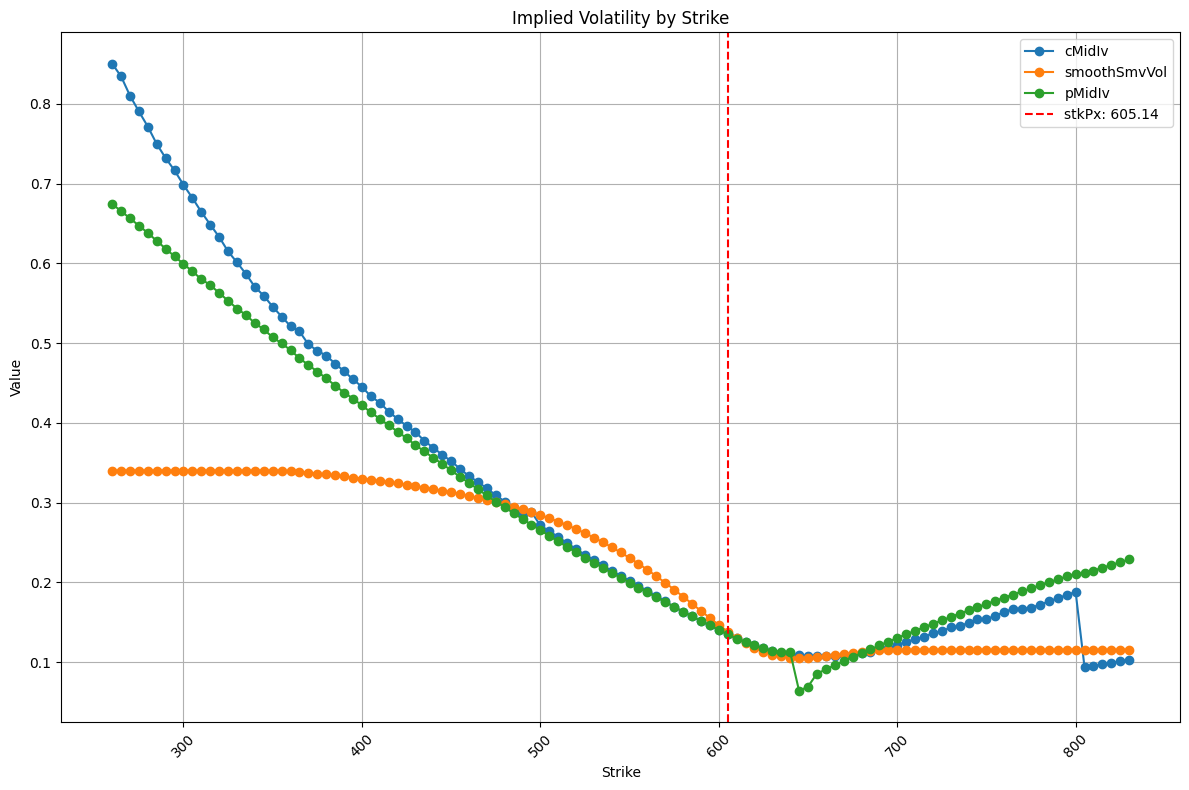

In [58]:
def plot_iv_vol_by_strike(df, strike_column='strike', stkpx_column='stkPx'):
    """
    Plots columns containing 'Iv' or 'Vol' against the strike column.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        strike_column (str): The name of the strike column.
    """

    # Identify columns containing 'Iv' or 'Vol'
    iv_vol_columns = [col for col in df.columns if 'MidIv' in col or 'smoothSmvVol' in col]

    if not iv_vol_columns:
        print("No columns containing 'MidIv' or 'smoothSmvVol' found.")
        return

    try:
        # Sort the DataFrame by strike
        df_sorted = df.sort_values(by=strike_column)

        plt.figure(figsize=(12, 8))  # Adjust figure size as needed

        for col in iv_vol_columns:
            plt.plot(df_sorted[strike_column], df_sorted[col], label=col, marker='o')
        
        # Add vertical line at stkPx
        stk_px_value = df_sorted[stkpx_column].iloc[0] #Take the first stkPx.
        plt.axvline(x=stk_px_value, color='red', linestyle='--', label=f'stkPx: {stk_px_value}')



        plt.title('Implied Volatility by Strike')
        plt.xlabel('Strike')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except KeyError:
        print(f"Error: Column '{strike_column}' not found in DataFrame.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Example usage (assuming your DataFrame is named filtered_data)
plot_iv_vol_by_strike(filtered_data)

In [119]:
def get_nearest_strikes_per_ticker(df, strike_column='strike', stkpx_column='stkPx', expir_date_column='expirDate', ticker_column='ticker'):
    """
    Gets the two strikes nearest to the stock price per expirDate and ticker.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        strike_column (str): The name of the strike column.
        stkpx_column (str): The name of the stock price column.
        expir_date_column (str): The name of the expiration date column.
        ticker_column (str): The name of the ticker column.

    Returns:
        pd.DataFrame: A DataFrame with the two nearest strikes per expirDate and ticker.
    """

    try:
        df[expir_date_column] = pd.to_datetime(df[expir_date_column])

        def nearest_strikes(group):
            stk_px = group[stkpx_column].iloc[0]  # Take the first stock price per group
            group['distance'] = abs(group[strike_column] - stk_px)
            nearest = group.nsmallest(2, 'distance')
            return nearest

        nearest_strikes_df = df.groupby([expir_date_column, ticker_column]).apply(nearest_strikes).reset_index(drop=True)
        return nearest_strikes_df

    except KeyError:
        print(f"Error: Column '{strike_column}', '{stkpx_column}', '{expir_date_column}', or '{ticker_column}' not found.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

# Example usage (assuming your DataFrame is named filtered_data)
nearest_strikes_result = get_nearest_strikes_per_ticker(filtered_data)
nearest_strikes_expiry_result = get_nearest_strikes_per_ticker(base_df)

nearest_strikes_result

,ticker,cOpra,pOpra,stkPx,expirDate,yte,strike,cVolu,cOi,pVolu,pOi,cBidPx,cValue,cAskPx,pBidPx,pValue,pAskPx,cBidIv,cMidIv,cAskIv,smoothSmvVol,pBidIv,pMidIv,pAskIv,iRate,divRate,residualRateData,delta,gamma,theta,vega,rho,phi,driftlessTheta,extVol,extCTheo,extPTheo,spot_px,trade_date,distance
0,VIX,VIX250416C00018000,VIX250416P00018000,17.885,2025-04-16,0.21370,18.0,7636.0,41987.0,3047.0,53532.0,2.38,2.42,2.43,2.50,2.52,2.55,0.740981,0.74871,0.756432,0.744147,0.750485,0.75821,0.765940,0.0432,0.0,0.035719,0.559249,0.063998,-0.015462,0.032377,0.014832,-0.019069,-0.015395,1.096306,3.520865,3.610226,17.22,2025-01-28,0.115
1,VIX,VIX250416C00017000,VIX250416P00017000,17.885,2025-04-16,0.21370,17.0,156.0,2292.0,4101.0,31910.0,2.70,2.70,2.72,1.80,1.83,1.84,0.697104,0.70031,0.703519,0.688345,0.698346,0.70476,0.711179,0.0432,0.0,0.035719,0.623130,0.066506,-0.013728,0.031198,0.016250,-0.020871,-0.013679,1.098164,3.939739,3.035957,17.22,2025-01-28,0.885
2,A,A250417C00150000,A250417P00150000,150.860,2025-04-17,0.21644,150.0,0.0,19.0,0.0,30.0,8.20,8.29,8.50,6.00,6.13,6.30,0.252124,0.25758,0.263036,0.243361,0.251310,0.25677,0.262224,0.0432,0.0,-0.008634,0.574929,0.022989,-0.051842,0.274756,0.170427,-0.187646,-0.042380,0.283256,9.056090,6.878505,0.00,2025-01-28,0.860
3,A,A250417C00155000,A250417P00155000,150.860,2025-04-17,0.21644,155.0,3.0,52.0,0.0,30.0,5.60,5.75,5.90,8.50,8.61,8.80,0.243261,0.24866,0.254069,0.233789,0.244321,0.24979,0.255254,0.0432,0.0,-0.007543,0.455764,0.024225,-0.048676,0.278190,0.137207,-0.148753,-0.041214,0.275148,6.483970,9.345746,0.00,2025-01-28,4.140
4,AA,AA250417C00035000,AA250417P00035000,34.340,2025-04-17,0.21644,35.0,78.0,2307.0,11.0,3545.0,2.66,2.69,2.74,3.05,3.08,3.15,0.444650,0.45093,0.457208,0.445286,0.445038,0.45290,0.460763,0.0432,0.0,-0.010028,0.519600,0.056105,-0.019532,0.063724,0.032839,-0.038602,-0.017923,0.447368,2.677322,3.064822,0.00,2025-01-28,0.660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7597,ZWS,ZWS250516C00037500,ZWS250516P00037500,39.320,2025-05-16,0.29589,37.5,0.0,1.0,0.0,2.0,2.15,4.06,6.00,0.00,1.79,4.50,0.000000,0.28935,0.578696,0.334584,0.000000,0.33651,0.673022,0.0425,0.0,-0.007378,0.661849,0.051118,-0.014634,0.078242,0.064973,-0.076978,-0.012097,0.334890,4.060658,1.796962,0.00,2025-01-28,1.820
7598,ZYXI,ZYXI250516C00007500,ZYXI250516P00007500,8.040,2025-05-16,0.29589,7.5,0.0,2.0,0.0,5.0,0.50,1.90,4.70,0.00,1.28,0.75,0.000000,1.44030,2.880594,0.945325,0.000000,0.30903,0.618067,0.0425,0.0,0.000000,0.661642,0.088717,-0.007429,0.015988,0.010101,-0.015736,-0.007031,0.856634,1.762738,1.135240,0.00,2025-01-28,0.540
7599,ZYXI,ZYXI250516C00010000,ZYXI250516P00010000,8.040,2025-05-16,0.29589,10.0,0.0,34.0,0.0,11.0,0.00,1.04,1.20,1.60,2.89,4.80,0.000000,0.51880,1.037593,0.943571,0.000000,1.03116,2.062328,0.0425,0.0,0.000000,0.442601,0.095936,-0.007869,0.017118,0.007457,-0.010526,-0.007575,0.855045,0.885377,2.740637,0.00,2025-01-28,1.960
7600,ZZZ,ZZZ250516C00028600,ZZZ250516P00028600,28.160,2025-05-16,0.29589,28.6,0.0,0.0,0.0,0.0,0.05,1.43,2.80,0.00,1.55,5.00,0.014108,0.23957,0.465026,0.240978,0.000000,0.40545,0.810894,0.0425,0.0,0.000000,0.516974,0.108458,-0.008370,0.060876,0.038822,-0.043063,-0.006842,0.240494,1.430609,1.550301,0.00,2025-01-28,0.440


In [198]:
def calculate_weighted_average_columns_per_ticker(df, strike_column='strike', stkpx_column='stkPx', expir_date_column='expirDate', ticker_column='ticker'):
    """
    Calculates the stock price weighted average of numerical values between two strikes per expir date and ticker,
    keeping the original column structure, and handles single-row groups correctly.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        strike_column (str): The name of the strike column.
        stkpx_column (str): The name of the stock price column.
        expir_date_column (str): The name of the expiration date column.
        ticker_column (str): The name of the ticker column.

    Returns:
        pd.DataFrame: A DataFrame with the weighted average of numerical values per expir date and ticker.
    """

    try:
        # Ensure expirDate is datetime
        df[expir_date_column] = pd.to_datetime(df[expir_date_column])

        def weighted_avg(group):
            stk_px = group[stkpx_column].iloc[0]
            strikes = group[strike_column].values
            
            if len(strikes) != 2:
                # Handle single-row or empty groups: return the group's first row as DataFrame
                if len(group) > 0:
                    return pd.DataFrame([group.iloc[0].to_dict()])
                else:
                    return None  # Or pd.DataFrame() if you prefer empty DataFrames

            lower_strike = min(strikes)
            upper_strike = max(strikes)

            if not (lower_strike <= stk_px <= upper_strike):
                return None  # return None if stock price is not between strikes.

            weight_upper = (stk_px - lower_strike) / (upper_strike - lower_strike)
            weight_lower = 1 - weight_upper

            result = {}
            for col in group.select_dtypes(include='number').columns:
                if col not in [strike_column, ticker_column, expir_date_column, stkpx_column]:
                    lower_val = group.loc[group[strike_column] == lower_strike, col].iloc[0]
                    upper_val = group.loc[group[strike_column] == upper_strike, col].iloc[0]
                    result[col] = lower_val * weight_lower + upper_val * weight_upper

            # # Add non-numeric columns from the first row of each group
            # for col in group.columns:
            #     if col not in group.select_dtypes(include='number').columns:
            #         result[col] = group[col].iloc[0]

            return pd.DataFrame([result])  # Create a DataFrame from the result dict

        weighted_averages = df.groupby([expir_date_column, ticker_column]).apply(weighted_avg)

        # # Remove the multiindex.
        # if isinstance(weighted_averages.index, pd.MultiIndex): #Check if it's a multiindex before trying to remove levels.
        #     weighted_averages.index = weighted_averages.index.get_level_values(0).droplevel(0)

        return weighted_averages.reset_index()

    except KeyError as e:
        print(f"KeyError: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None
    
# Example usage (assuming your DataFrame is named filtered_data)
weighted_avg_result = calculate_weighted_average_columns_per_ticker(nearest_strikes_result)

,expirDate,ticker,level_2,yte,cVolu,cOi,pVolu,pOi,cBidPx,cValue,cAskPx,pBidPx,pValue,pAskPx,cBidIv,cMidIv,cAskIv,smoothSmvVol,pBidIv,pMidIv,pAskIv,iRate,divRate,residualRateData,delta,gamma,theta,vega,rho,phi,driftlessTheta,extVol,extCTheo,extPTheo,spot_px,distance
0,2025-04-16,VIX,0,0.21370,6775.800,37422.075,3168.210,51045.470,2.41680,2.45220,2.46335,2.4195,2.44065,2.46835,0.735935,0.743144,0.750347,0.737730,0.744489,0.752063,0.759642,0.0432,0.0,0.035719,0.566595,0.064286,-0.015262,0.032241,0.014995,-0.019276,-0.015198,1.096520,3.569036,3.544185,17.22,0.20355
1,2025-04-17,A,0,0.21644,0.516,24.676,0.000,30.000,7.75280,7.85312,8.05280,6.4300,6.55656,6.73000,0.250600,0.256046,0.261494,0.241715,0.250108,0.255569,0.261025,0.0432,0.0,-0.008446,0.554433,0.023202,-0.051298,0.275347,0.164713,-0.180957,-0.042179,0.281861,8.613686,7.302871,0.00,1.42416
2,2025-04-17,AA,0,0.21644,70.740,2187.144,14.564,3375.512,3.04808,3.08600,3.13732,2.7860,2.81864,2.88204,0.446567,0.454116,0.461665,0.449034,0.447671,0.455483,0.463296,0.0432,0.0,-0.010028,0.553324,0.053907,-0.019116,0.061458,0.034487,-0.041108,-0.017440,0.450632,3.071049,2.803249,0.00,1.14576
3,2025-04-17,AADI,0,0.21644,0.000,336.160,0.000,3.360,0.46200,0.33600,2.04400,0.0840,1.74520,3.72400,1.708018,3.210976,4.713936,0.403543,0.028053,0.817908,1.607758,0.0432,0.0,4.358993,0.840000,0.000000,0.000000,0.000010,0.000000,0.000000,0.000000,0.690600,0.336000,1.745238,0.00,0.67200
4,2025-04-17,AAON,0,0.21644,0.000,0.302,0.000,9.074,7.27520,9.18258,10.65440,6.8456,8.81312,10.75500,0.341896,0.424830,0.507764,0.435411,0.338828,0.434738,0.530652,0.0432,0.0,0.022900,0.544519,0.017428,-0.057983,0.203788,0.110731,-0.130145,-0.055968,0.503764,10.569999,10.212135,0.00,2.10796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3553,2025-05-16,ZVIA,0,0.29589,4.504,521.464,0.000,250.184,1.06000,1.36256,1.52200,0.9772,1.27248,1.46480,0.944525,1.274733,1.604948,1.358985,0.990380,1.303831,1.617279,0.0425,0.0,-0.037394,0.653657,0.108450,-0.005481,0.008255,0.004434,-0.008469,-0.005153,1.407689,1.399538,1.309505,0.00,0.93248
3554,2025-05-16,ZVRA,0,0.29589,0.000,400.920,0.000,22.620,1.04400,1.37190,1.97700,0.0000,1.28190,2.25100,0.620996,0.902783,1.184567,0.782528,0.000000,0.723505,1.447015,0.0425,0.0,0.000000,0.594375,0.115881,-0.006383,0.016530,0.009773,-0.013837,-0.005998,0.794342,1.393383,1.303338,0.00,0.22620
3555,2025-05-16,ZWS,0,0.29589,0.000,2.456,0.000,22.384,0.98520,3.04808,5.12640,0.7280,2.59080,4.71840,0.054009,0.314757,0.575499,0.326309,0.070118,0.326100,0.582081,0.0425,0.0,-0.007378,0.561311,0.055961,-0.014788,0.083445,0.056273,-0.065285,-0.012578,0.326608,3.049026,2.597119,0.00,0.99008
3556,2025-05-16,ZYXI,0,0.29589,0.000,8.912,0.000,6.296,0.39200,1.71424,3.94400,0.3456,1.62776,1.62480,0.000000,1.241256,2.482506,0.944946,0.000000,0.465010,0.930027,0.0425,0.0,0.000000,0.614329,0.090276,-0.007524,0.016232,0.009530,-0.014610,-0.007149,0.856291,1.573228,1.482006,0.00,0.84672


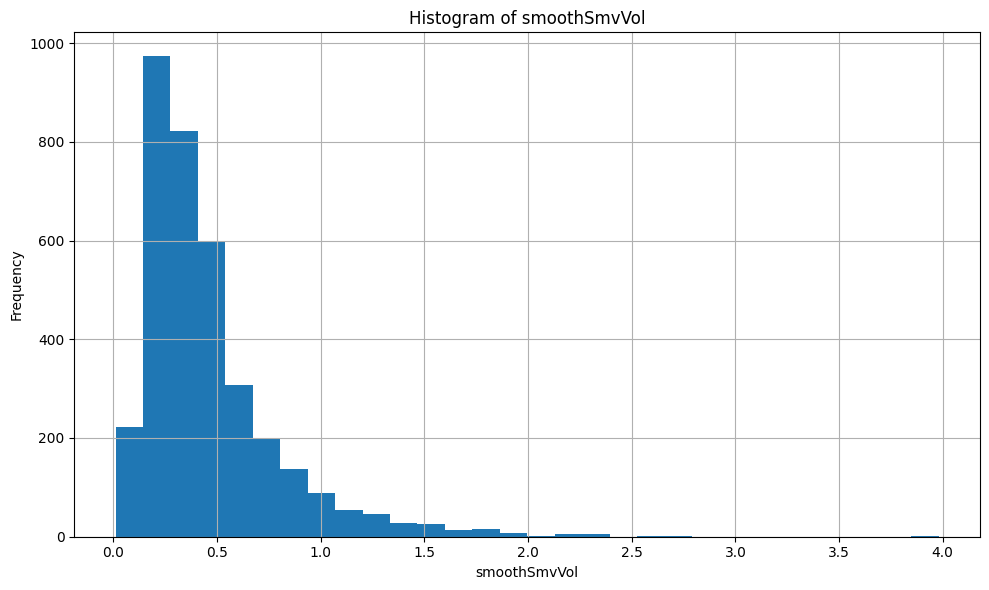

In [111]:
def plot_histogram(df, column_to_plot):
    """
    Plots a histogram of a specified column.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        column_to_plot (str): The name of the column to plot.
    """

    try:
        plt.figure(figsize=(10, 6))  # Adjust figure size as needed
        df[column_to_plot].hist(bins=30)  # You can adjust the number of bins
        plt.title(f'Histogram of {column_to_plot}')
        plt.xlabel(column_to_plot)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except KeyError:
        print(f"Error: Column '{column_to_plot}' not found in DataFrame.")
    except TypeError:
        print(f"Error: Column '{column_to_plot}' is not suitable for a histogram.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Example usage (assuming your DataFrame is named spy_base_df)
plot_histogram(weighted_avg_result, 'smoothSmvVol');
# plot_histogram(spy_base_df, 'stkPx')

In [112]:
def plot_histogram_interactive(df, column_name):
    """
    Plots a histogram of a specified column (for interactive use).

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to plot.
    """

    plt.figure(figsize=(10, 6))
    if column_name in df.columns:
        df[column_name].hist(bins=30)
        plt.title(f'Histogram of {column_name}')
        plt.xlabel(column_name)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Error: Column '{column_name}' not found in DataFrame.")

In [115]:
def create_plot_interface(df):
    """
    Creates interactive buttons to plot histograms for DataFrame columns.

    Args:
        df (pd.DataFrame): The DataFrame to plot from.
    """

    column_names = df.columns.tolist()
    buttons = []

    for col in column_names:
        button = widgets.Button(description=col)
        def on_button_clicked(b, column=col):  # Capture 'col' in a closure
            plot_histogram_interactive(df, column)
        button.on_click(on_button_clicked)
        buttons.append(button)

    display(widgets.HBox(buttons))  # Display buttons horizontally

# Example Usage:
create_plot_interface(weighted_avg_result[['yte', 'cBidIv',
       'cMidIv', 'cAskIv', 'smoothSmvVol', 'pBidIv', 'pMidIv', 'pAskIv',
       'iRate', 'divRate', 'residualRateData', 'extVol']].copy()) # Use a copy to avoid unintended modifications

In [124]:
def plot_column_by_expir_date(df, column_to_plot, expir_date_column='expirDate'):
    """
    Plots a specified column against expirDate.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        column_to_plot (str): The name of the column to plot against expirDate.
        expir_date_column (str): The name of the expirDate column (datetime type).
    """

    try:
        # Ensure expirDate is datetime
        df[expir_date_column] = pd.to_datetime(df[expir_date_column])

        # Sort the DataFrame by expirDate to ensure proper chronological plotting
        df_sorted = df.sort_values(by=expir_date_column)

        plt.figure(figsize=(10, 6))  # Adjust figure size as needed
        plt.plot(df_sorted[expir_date_column], df_sorted[column_to_plot], marker='o') #plot the column.
        plt.title(f'{column_to_plot} by Expiration Date')
        plt.xlabel('Expiration Date')
        plt.ylabel(column_to_plot)
        plt.grid(True)
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.tight_layout()
        plt.show()

    except KeyError:
        print(f"Error: Column '{column_to_plot}' or '{expir_date_column}' not found in DataFrame.")
    except TypeError:
        print(f"Error: '{expir_date_column}' is not a datetime column.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


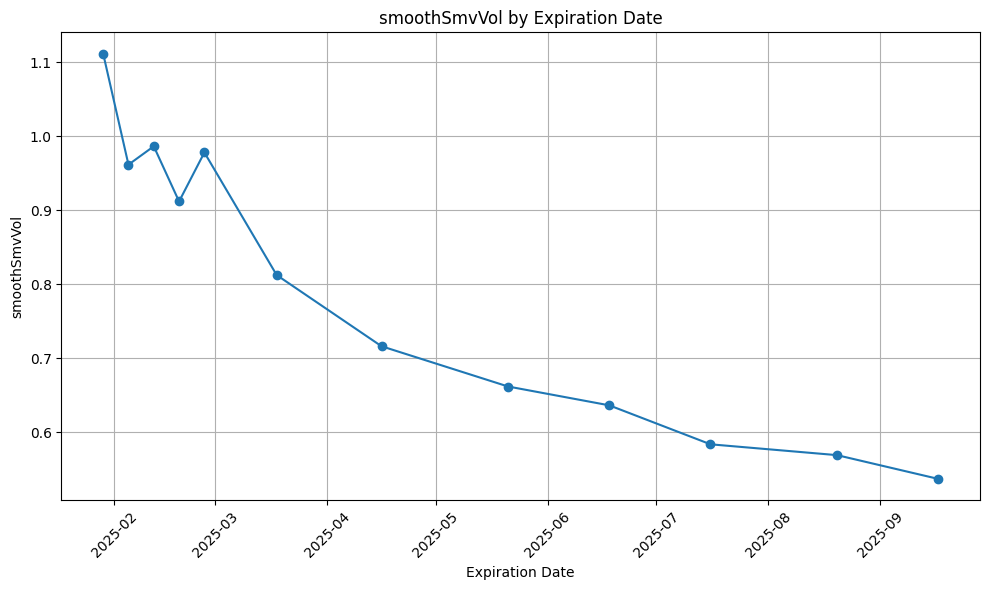

In [131]:
ticker = "AAPL"
check = nearest_strikes_expiry_result.query("ticker == 'VIX'")[["expirDate", "smoothSmvVol"]].groupby("expirDate").mean().reset_index()
plot_column_by_expir_date(check, 'smoothSmvVol')


In [137]:
# Assuming you have nearest_strikes_expiry_result defined
def create_interactive_ticker_plot(df, ticker_column='ticker', date_column='expirDate', value_column='smoothSmvVol'):
    """
    Creates an interactive Altair plot where you can select a ticker from a dropdown and hover over points to see values.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        ticker_column (str): The name of the ticker column.
        date_column (str): The name of the expiration date column.
        value_column (str): The name of the column to plot (e.g., 'smoothSmvVol').
    """

    tickers = sorted(df[ticker_column].unique().tolist())
    ticker_dropdown = widgets.Dropdown(options=tickers, description='Select Ticker:', disabled=False)
    output = widgets.Output()

    def update_plot(selected_ticker):
        with output:
            output.clear_output(wait=True)
            try:
                check = df.query(f"{ticker_column} == '{selected_ticker}'")[[date_column, value_column]].groupby(date_column).mean().reset_index()

                # Create the Altair chart
                chart = alt.Chart(check).mark_line(point=True).encode(
                    x=alt.X(date_column, axis=alt.Axis(title=date_column)),
                    y=alt.Y(value_column, axis=alt.Axis(title=value_column)),
                    tooltip=[date_column, value_column]  # Add tooltip for hover
                ).interactive()  # Enable zooming and panning

                display(chart)

            except KeyError as e:
                print(f"Error: {e}")
            except Exception as e:
                print(f"An unexpected error occurred: {e}")

    def on_ticker_change(change):
        update_plot(change.new)

    ticker_dropdown.observe(on_ticker_change, names='value')
    display(ticker_dropdown, output)

# Example Usage:
create_interactive_ticker_plot(nearest_strikes_expiry_result)

Dropdown(description='Select Ticker:', options=('A', 'AA', 'AADI', 'AAL', 'AAMI', 'AAOI', 'AAON', 'AAP', 'AAPB…

Output()

In [249]:
def nelson_siegel_fit(df, ticker_col='ticker', expir_date_col='expirDate', vol_col='vol', yte_col='yte', output_vol_col='ns_fit', dte_fit_cutoff=21/365):
    """
    Fits the Nelson-Siegel model to volatility data for each ticker and expiration date,
    handling cases with insufficient data points.

    Args:
        df (pd.DataFrame): DataFrame with columns for ticker, expirDate, and volatility.
        ticker_col (str): Name of the ticker column.
        expir_date_col (str): Name of the expiration date column.
        vol_col (str): Name of the volatility column.
        yte_col (str): Name of the years to expiration column.
        output_vol_col (str): Name of the output column for the NS fit.

    Returns:
        pd.DataFrame: DataFrame with the original columns plus a 'ns_fit' column
                      containing the fitted volatility values.
    """

    def ns_curve(tau, beta0, beta1, beta2, lamda):
        """Nelson-Siegel curve function."""
        return beta0 + beta1 * (1 - np.exp(-tau / lamda)) / (tau / lamda) + \
               beta2 * ((1 - np.exp(-tau / lamda)) / (tau / lamda) - np.exp(-tau / lamda))

    def fit_ns_group(group_raw):
        """Fits the Nelson-Siegel curve to a group of volatility data."""
        group = group_raw.query(f"yte > {dte_fit_cutoff}").copy()
        tau = np.array(group[yte_col])
        vol = group[vol_col].values

        if len(tau) < 3:  # Need at least 3 points for a meaningful fit
            group[output_vol_col] = group[vol_col]  # Or np.nan, or some other handling
            print(f"Insufficient data points for fitting: {group.iloc[0][ticker_col]}, {group.iloc[0][expir_date_col]}")
            return group_raw

        # Initial guess for parameters (can be tuned)
        p0 = [0.1, -0.05, -0.05, 1.0]  # beta0, beta1, beta2, lambda
        try:
            popt, pcov = curve_fit(ns_curve, tau, vol, p0=p0,
                                 bounds=((-np.inf, -np.inf, -np.inf, 0.00001),
                                         (np.inf, np.inf, np.inf, np.inf)),
                                 maxfev=5000)  # Increase maxfev
            group[output_vol_col] = ns_curve(tau, *popt)
            group_raw = group_raw.merge(group[[expir_date_col, output_vol_col]], how="left")
        except (RuntimeError, TypeError) as e:
            print(f"Fit failed for group: {group.iloc[0][ticker_col]}, {group.iloc[0][expir_date_col]}. Error: {e}")
            group[output_vol_col] = np.nan  # Or some other default value
        return group_raw

    # Convert expirDate to datetime if needed
    if df[expir_date_col].dtype != 'datetime64[ns]':
        df[expir_date_col] = pd.to_datetime(df[expir_date_col])

    # Group by ticker and expirDate and apply the fitting function
    result_df = df.groupby([ticker_col], group_keys=False).apply(fit_ns_group)

    return result_df

In [250]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_vols_plot(df, vol_col1='smoothSmvVol', vol_col2='ns_fit', ticker_col='ticker', expir_date_col='expirDate'):
    """
    Compares two volatility columns, calculates metrics, and plots the two volatility lines.

    Args:
        df (pd.DataFrame): DataFrame with volatility columns.
        vol_col1 (str): Name of the first volatility column.
        vol_col2 (str): Name of the second volatility column.
        ticker_col (str): Name of the ticker column.
        expir_date_col (str): Name of the expiration date column.

    Returns:
        pd.DataFrame: DataFrame with the original columns and added comparison metrics.
    """

    try:
        df = df.copy()

        # Calculate the difference and percentage difference
        df['vol_diff'] = df[vol_col1] - df[vol_col2]
        df['vol_pct_diff'] = (df[vol_col1] - df[vol_col2]) / df[vol_col1] * 100
        df['vol_abs_pct_diff'] = abs(df['vol_pct_diff'])
        df['vol_sq_diff'] = df['vol_diff']**2

        # Group by ticker and expirDate for summary statistics
        grouped_stats = df.groupby([ticker_col]).agg(
            mean_diff=('vol_diff', 'mean'),
            std_diff=('vol_diff', 'std'),
            mean_pct_diff=('vol_pct_diff', 'mean'),
            std_pct_diff=('vol_pct_diff', 'std'),
            mean_abs_pct_diff=('vol_abs_pct_diff', 'mean'),
            mean_sq_diff=('vol_sq_diff', 'mean')
        ).reset_index()

        # Merge the statistics back into the original dataframe
        df = df.merge(grouped_stats, on=[ticker_col], how='left')

        # Print some summary statistics
        print(f"Volatility Comparison Statistics (Grouped by {ticker_col} and {expir_date_col}):\n")
        print(grouped_stats.to_markdown(index=False, numalign="left", stralign="left"))  # Use to_markdown for better formatting

        # Plot the two volatility columns
        plt.figure(figsize=(10, 6))
        plt.plot(df[expir_date_col], df[vol_col1], label=vol_col1, marker='o')
        plt.plot(df[expir_date_col], df[vol_col2], label=vol_col2, marker='x')
        plt.title(f'Volatility Comparison: {vol_col1} vs. {vol_col2}')
        plt.xlabel(expir_date_col)
        plt.ylabel('Volatility')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        return df

    except KeyError as e:
        print(f"KeyError: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

Volatility Comparison Statistics (Grouped by ticker and expirDate):

| ticker   | mean_diff   | std_diff   | mean_pct_diff   | std_pct_diff   | mean_abs_pct_diff   | mean_sq_diff   |
|:---------|:------------|:-----------|:----------------|:---------------|:--------------------|:---------------|
| NVDA     | 6.35468e-09 | 0.0276447  | -0.270938       | 5.5944         | 3.08957             | 0.000721771    |


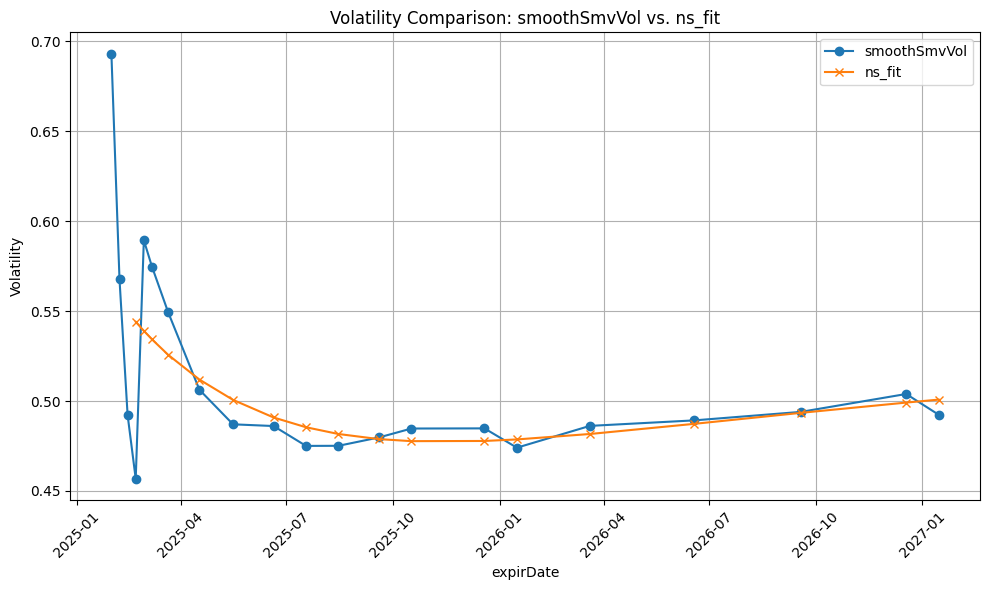

Volatility Comparison Statistics (Grouped by ticker and expirDate):

| ticker   | mean_diff   | std_diff   | mean_pct_diff   | std_pct_diff   | mean_abs_pct_diff   | mean_sq_diff   |
|:---------|:------------|:-----------|:----------------|:---------------|:--------------------|:---------------|
| NVDA     | -0.0561403  | 0.0437514  | -11.7309        | 8.32986        | 13.0813             | 0.00497477     |


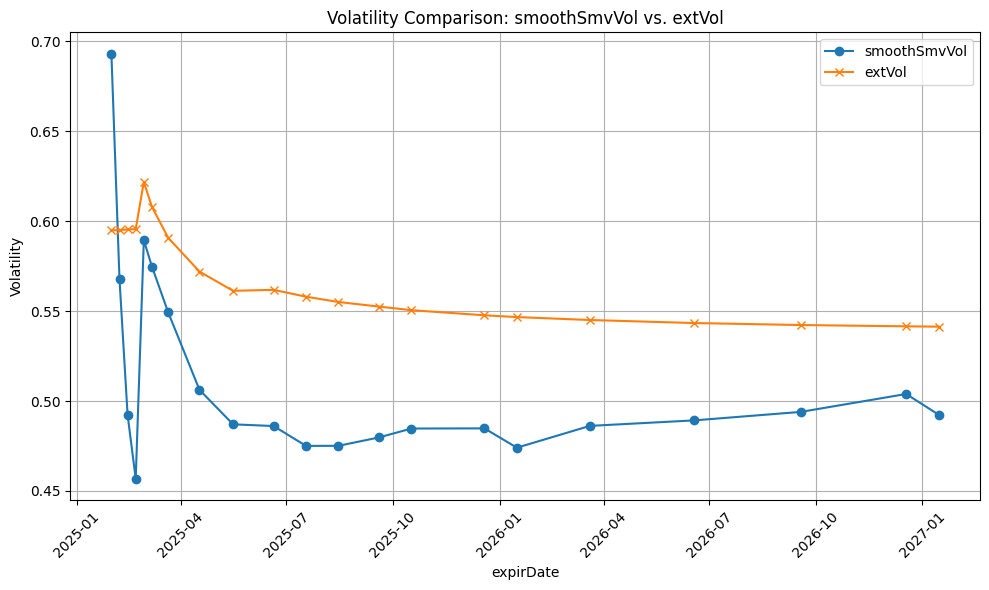

In [251]:
# Assuming you have a DataFrame named 'option_data' with columns 'ticker', 'expirDate', 'yte', and 'cMidIv'
# option_data['ns_fit'] = 0 # Initialize the ns_fit column
ticker = 'NVDA'
check = nearest_strikes_expiry_result[['ticker', 'expirDate', "yte", 'smoothSmvVol', 'extVol']].groupby(["ticker", "expirDate"]).mean().reset_index()
ns_fitted_data = nelson_siegel_fit(check.query(f"ticker == '{ticker}'"), ticker_col='ticker', expir_date_col='expirDate', vol_col='smoothSmvVol', output_vol_col='ns_fit')
compared_vols_df = compare_vols_plot(ns_fitted_data) 
compared_vols_df_two = compare_vols_plot(ns_fitted_data, vol_col2='extVol',)

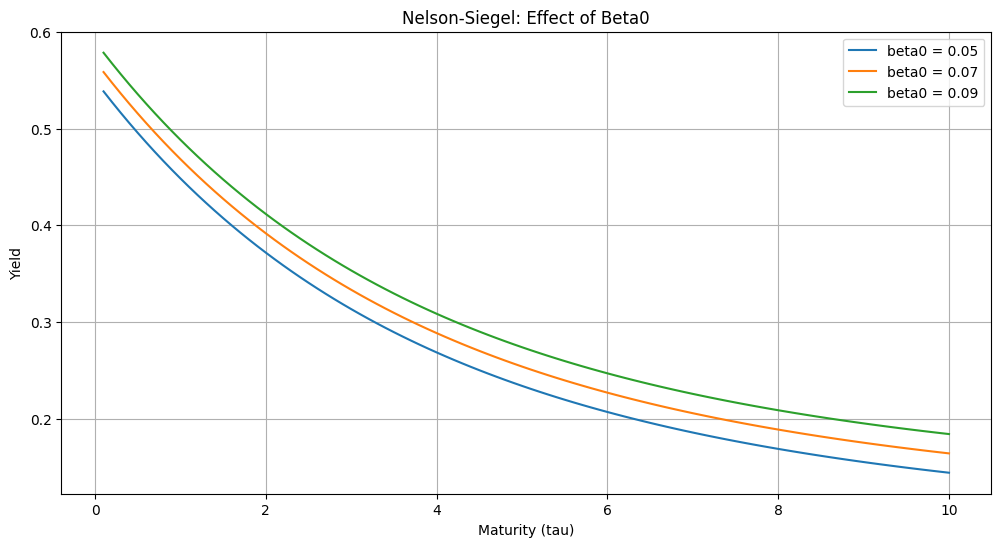

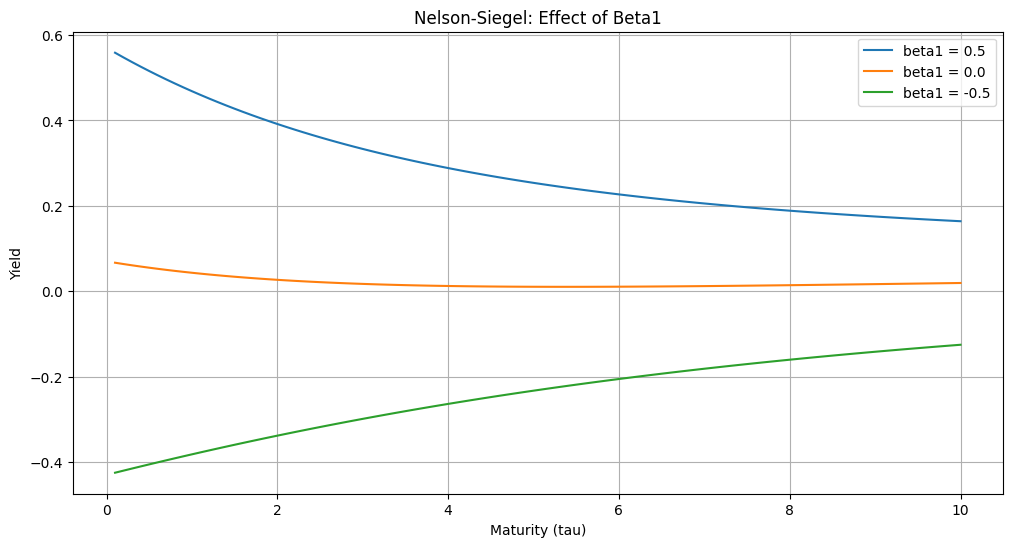

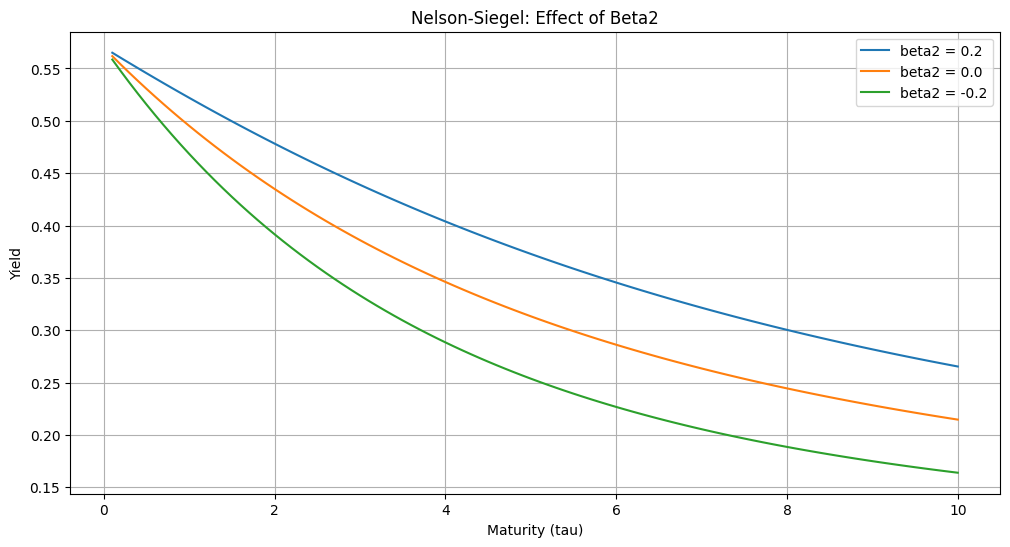

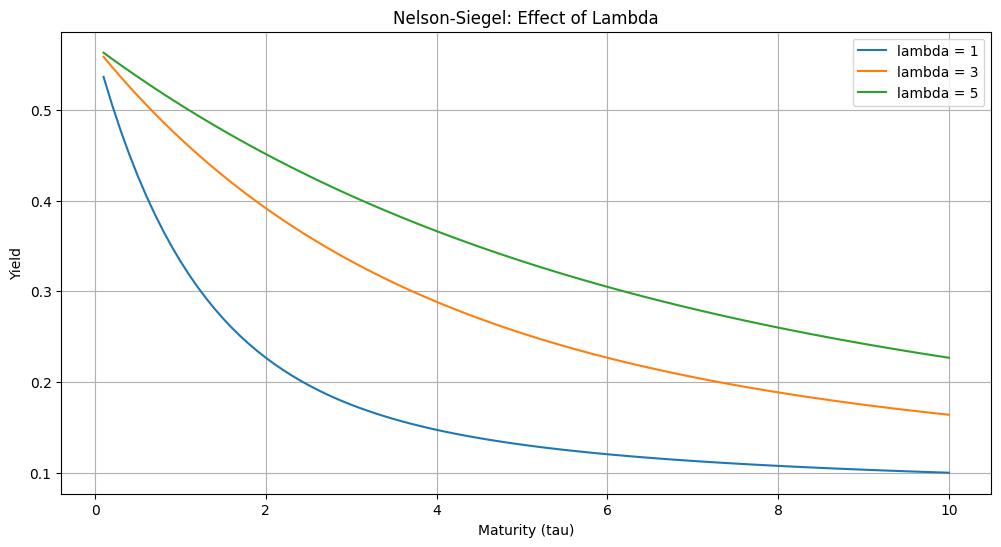

In [242]:
import numpy as np
import matplotlib.pyplot as plt

def nelson_siegel(tau, beta0, beta1, beta2, lamda):
    """Nelson-Siegel curve function."""
    return beta0 + beta1 * (1 - np.exp(-tau / lamda)) / (tau / lamda) + \
           beta2 * ((1 - np.exp(-tau / lamda)) / (tau / lamda) - np.exp(-tau / lamda))

# Define maturities (tau)
tau = np.linspace(0.1, 10, 100)  # Maturities from 0.1 to 10 years

# --- Effect of Beta0 (Long-Term Level) ---
plt.figure(figsize=(12, 6))
beta1, beta2, lamda = 0.5, -0.2, 3  # Keep other parameters constant

plt.plot(tau, nelson_siegel(tau, 0.05, beta1, beta2, lamda), label='beta0 = 0.05')
plt.plot(tau, nelson_siegel(tau, 0.07, beta1, beta2, lamda), label='beta0 = 0.07')
plt.plot(tau, nelson_siegel(tau, 0.09, beta1, beta2, lamda), label='beta0 = 0.09')
plt.title('Nelson-Siegel: Effect of Beta0')
plt.xlabel('Maturity (tau)')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()

# --- Effect of Beta1 (Short-Term Level/Slope) ---
plt.figure(figsize=(12, 6))
beta0, beta2, lamda = 0.07, -0.2, 3

plt.plot(tau, nelson_siegel(tau, beta0, 0.5, beta2, lamda), label='beta1 = 0.5')
plt.plot(tau, nelson_siegel(tau, beta0, 0.0, beta2, lamda), label='beta1 = 0.0')
plt.plot(tau, nelson_siegel(tau, beta0, -0.5, beta2, lamda), label='beta1 = -0.5')
plt.title('Nelson-Siegel: Effect of Beta1')
plt.xlabel('Maturity (tau)')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()

# --- Effect of Beta2 (Curvature) ---
plt.figure(figsize=(12, 6))
beta0, beta1, lamda = 0.07, 0.5, 3

plt.plot(tau, nelson_siegel(tau, beta0, beta1, 0.2, lamda), label='beta2 = 0.2')
plt.plot(tau, nelson_siegel(tau, beta0, beta1, 0.0, lamda), label='beta2 = 0.0')
plt.plot(tau, nelson_siegel(tau, beta0, beta1, -0.2, lamda), label='beta2 = -0.2')
plt.title('Nelson-Siegel: Effect of Beta2')
plt.xlabel('Maturity (tau)')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()

# --- Effect of Lambda (Curvature Shift) ---
plt.figure(figsize=(12, 6))
beta0, beta1, beta2 = 0.07, 0.5, -0.2

plt.plot(tau, nelson_siegel(tau, beta0, beta1, beta2, 1), label='lambda = 1')
plt.plot(tau, nelson_siegel(tau, beta0, beta1, beta2, 3), label='lambda = 3')
plt.plot(tau, nelson_siegel(tau, beta0, beta1, beta2, 5), label='lambda = 5')
plt.title('Nelson-Siegel: Effect of Lambda')
plt.xlabel('Maturity (tau)')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()

In [212]:
nearest_strikes_expiry_result.head()

,ticker,cOpra,pOpra,stkPx,expirDate,yte,strike,cVolu,cOi,pVolu,pOi,cBidPx,cValue,cAskPx,pBidPx,pValue,pAskPx,cBidIv,cMidIv,cAskIv,smoothSmvVol,pBidIv,pMidIv,pAskIv,iRate,divRate,residualRateData,delta,gamma,theta,vega,rho,phi,driftlessTheta,extVol,extCTheo,extPTheo,spot_px,trade_date,distance
0,IWM,IWM250128C00227000,IWM250128P00227000,227.20,2025-01-28,0.0,227.0,75697.0,1768.0,25908.0,1793.0,0.25,0.26,0.28,0.06,0.06,0.08,0.122100,0.13847,0.154844,0.138576,0.127840,0.13870,0.149552,0.0444,0.0,0.226193,0.704036,0.951624,-0.069896,0.009184,0.000174,-0.000174,-1.275755,0.141617,0.267712,0.072697,0.00,2025-01-28,0.20
1,IWM,IWM250128C00228000,IWM250128P00228000,227.20,2025-01-28,0.0,228.0,67411.0,3490.0,2836.0,1229.0,0.00,0.00,0.01,0.76,0.81,0.83,0.000000,0.09160,0.183201,0.124417,0.000000,0.11196,0.223913,0.0444,0.0,0.226193,0.007256,0.060789,-0.000793,0.000515,0.000002,-0.000002,-0.066515,0.127147,0.000958,0.806610,0.00,2025-01-28,0.80
2,NDX,NDX250128C21475000,NDX250128P21475000,21474.80,2025-01-28,0.0,21475.0,523.0,20.0,171.0,2.0,12.00,12.87,13.80,11.80,13.07,14.20,0.120993,0.12997,0.138945,0.132325,0.116244,0.12821,0.140180,0.0444,0.0,0.071462,0.497113,0.012057,-13.136277,1.002691,0.013228,-0.013244,-133.294220,0.176505,17.566122,17.842369,21466.66,2025-01-28,0.20
3,NDX,NDX250128C21470000,NDX250128P21470000,21474.80,2025-01-28,0.0,21470.0,568.0,6.0,121.0,17.0,14.60,15.53,16.60,10.00,10.79,11.80,0.120432,0.13050,0.140574,0.135113,0.121689,0.13075,0.139815,0.0444,0.0,0.071462,0.555798,0.011683,-11.333084,0.992973,0.014594,-0.014613,-134.637299,0.182137,20.726763,16.002272,21466.66,2025-01-28,4.80
4,QQQ,QQQ250128C00522000,QQQ250128P00522000,522.47,2025-01-28,0.0,522.0,174314.0,3788.0,103947.0,979.0,0.68,0.70,0.70,0.23,0.22,0.24,0.167706,0.17222,0.176738,0.166358,0.172098,0.17435,0.176606,0.0444,0.0,0.203919,0.676067,0.356970,-0.217264,0.022153,0.000397,-0.000397,-3.666502,0.200371,0.753013,0.293413,0.00,2025-01-28,0.47


In [214]:
def filter_df_by_matching_tickers(df1, df2, ticker_col1='ticker', ticker_col2='ticker'):
    """
    Filters df1 to include only tickers present in df2.

    Args:
        df1 (pd.DataFrame): The DataFrame to be filtered.
        df2 (pd.DataFrame): The DataFrame containing the tickers to match.
        ticker_col1 (str): The name of the ticker column in df1.
        ticker_col2 (str): The name of the ticker column in df2.

    Returns:
        pd.DataFrame: A filtered version of df1.
    """

    # Get the unique tickers from df2
    matching_tickers = set(df2[ticker_col2])

    # Filter df1 to keep only rows where the ticker is in the set of matching tickers
    filtered_df1 = df1[df1[ticker_col1].isin(matching_tickers)].copy()  # Use .copy() to avoid SettingWithCopyWarning

    return filtered_df1

# Example Usage
# Assuming you have two DataFrames named 'df_options' and 'df_trades'
# and both have a column named 'ticker'

# filtered_options_df = filter_df_by_matching_tickers(df_options, df_trades)
# print(filtered_options_df)

In [215]:
weighted_avg_expir_result = calculate_weighted_average_columns_per_ticker(filter_df_by_matching_tickers(nearest_strikes_expiry_result, all_earnings_df))

In [229]:
all_earnings_df

,ticker,tradeDate,assetType,priorCls,pxAtmIv,mktCap,cVolu,cOi,pVolu,pOi,orFcst20d,orIvFcst20d,orFcstInf,orIvXern20d,orIvXernInf,iv200Ma,atmIvM1,atmFitIvM1,atmFcstIvM1,dtExM1,atmIvM2,atmFitIvM2,atmFcstIvM2,dtExM2,atmIvM3,atmFitIvM3,atmFcstIvM3,dtExM3,atmIvM4,atmFitIvM4,atmFcstIvM4,dtExM4,iRate5wk,iRateLt,px1kGam,volOfVol,volOfIvol,slope,slopeInf,slopeFcst,slopeFcstInf,deriv,derivInf,derivFcst,derivFcstInf,mktWidthVol,mktWidthVolInf,cAddPrem,pAddPrem,rip,ivEarnReturn,fcstR2,fcstR2Imp,hiHedge,loHedge,stkVolu,avgOptVolu20d,sector,orHv1d,orHv5d,orHv10d,orHv20d,orHv60d,orHv90d,orHv120d,orHv252d,orHv500d,orHv1000d,clsHv5d,clsHv10d,clsHv20d,clsHv60d,clsHv90d,clsHv120d,clsHv252d,clsHv500d,clsHv1000d,iv20d,iv30d,iv60d,iv90d,iv6m,clsPx1w,stkPxChng1wk,clsPx1m,stkPxChng1m,clsPx6m,stkPxChng6m,clsPx1y,stkPxChng1y,divFreq,divYield,divGrwth,divDate,divAmt,nextErn,nextErnTod,lastErn,lastErnTod,absAvgErnMv,impliedIee,daysToNextErn,tkOver,etfIncl,bestEtf,sectorName,correlSpy1m,correlSpy1y,correlEtf1m,correlEtf1y,beta1m,beta1y,ivPctile1m,ivPctile1y,ivPctileSpy,ivPctileEtf,ivStdvMean,ivStdv1y,ivSpyRatio,ivSpyRatioAvg1m,ivSpyRatioAvg1y,ivSpyRatioStdv1y,ivEtfRatio,ivEtfRatioAvg1m,ivEtfRatioAvg1y,ivEtFratioStdv1y,ivHvXernRatio,ivHvXernRatio1m,ivHvXernRatio1y,ivHvXernRatioStdv1y,etfIvHvXernRatio,etfIvHvXernRatio1m,etfIvHvXernRatio1y,etfIvHvXernRatioStdv1y,slopepctile,slopeavg1m,slopeavg1y,slopeStdv1y,etfSlopeRatio,etfSlopeRatioAvg1m,etfSlopeRatioAvg1y,etfSlopeRatioAvgStdv1y,impliedR2,contango,nextDiv,impliedNextDiv,annActDiv,annIdiv,borrow30,borrow2yr,error,confidence,pxCls,wksNextErn,ernMnth,oi,straPxM1,straPxM2,smoothStraPxM1,smoothStrPxM2,fcstStraPxM1,fcstStraPxM2,loStrikeM1,hiStrikeM1,loStrikeM2,hiStrikeM2,ernDate1,ernDate2,ernDate3,ernDate4,ernDate5,ernDate6,ernDate7,ernDate8,ernDate9,ernDate10,ernDate11,ernDate12,ernMv1,ernMv2,ernMv3,ernMv4,ernMv5,ernMv6,ernMv7,ernMv8,ernMv9,ernMv10,ernMv11,ernMv12,ernStraPct1,ernStraPct2,ernStraPct3,ernStraPct4,ernStraPct5,ernStraPct6,ernStraPct7,ernStraPct8,ernStraPct9,ernStraPct10,ernStraPct11,ernStraPct12,ernEffct1,ernEffct2,ernEffct3,ernEffct4,ernEffct5,ernEffct6,ernEffct7,ernEffct8,ernEffct9,ernEffct10,ernEffct11,ernEffct12,orHvXern5d,orHvXern10d,orHvXern20d,orHvXern60d,orHvXern90d,orHvXern120d,orHvXern252d,orHvXern500d,orHvXern1000d,clsHvXern5d,clsHvXern10d,clsHvXern20d,clsHvXern60d,clsHvXern90d,clsHvXern120d,clsHvXern252d,clsHvXern500d,clsHvXern1000d,iv10d,iv1yr,fcstSlope,fcstErnEffct,ernMvStdv,impliedEe,impErnMv,impMth2ErnMv,fairVol90d,fairXieeVol90d,fairMth2XieeVol90d,impErnMv90d,impErnMvMth290d,exErnIv10d,exErnIv20d,exErnIv30d,exErnIv60d,exErnIv90d,exErnIv6m,exErnIv1yr,dlt5Iv10d,dlt5Iv20d,dlt5Iv30d,dlt5Iv60d,dlt5Iv90d,dlt5Iv6m,dlt5Iv1y,exErnDlt5Iv10d,exErnDlt5Iv20d,exErnDlt5Iv30d,exErnDlt5Iv60d,exErnDlt5Iv90d,exErnDlt5Iv6m,exErnDlt5Iv1y,dlt25Iv10d,dlt25Iv20d,dlt25Iv30d,dlt25Iv60d,dlt25Iv90d,dlt25Iv6m,dlt25Iv1y,exErnDlt25Iv10d,exErnDlt25Iv20d,exErnDlt25Iv30d,exErnDlt25Iv60d,exErnDlt25Iv90d,exErnDlt25Iv6m,exErnDlt25Iv1y,dlt75Iv10d,dlt75Iv20d,dlt75Iv30d,dlt75Iv60d,dlt75Iv90d,dlt75Iv6m,dlt75Iv1y,exErnDlt75Iv10d,exErnDlt75Iv20d,exErnDlt75Iv30d,exErnDlt75Iv60d,exErnDlt75Iv90d,exErnDlt75Iv6m,exErnDlt75Iv1y,dlt95Iv10d,dlt95Iv20d,dlt95Iv30d,dlt95Iv60d,dlt95Iv90d,dlt95Iv6m,dlt95Iv1y,exErnDlt95Iv10d,exErnDlt95Iv20d,exErnDlt95Iv30d,exErnDlt95Iv60d,exErnDlt95Iv90d,exErnDlt95Iv6m,exErnDlt95Iv1y,fwd30_20,fwd60_30,fwd90_60,fwd180_90,fwd90_30,fexErn30_20,fexErn60_30,fexErn90_60,fexErn180_90,fexErn90_30,ffwd30_20,ffwd60_30,ffwd90_60,ffwd180_90,ffwd90_30,ffexErn30_20,ffexErn60_30,ffexErn90_60,ffexErn180_90,ffexErn90_30,fbfwd30_20,fbfwd60_30,fbfwd90_60,fbfwd180_90,fbfwd90_30,fbfexErn30_20,fbfexErn60_30,fbfexErn90_60,fbfexErn180_90,fbfexErn90_30,impliedEarningsMove,updatedAt
0,AAPL,2025-01-28,3,229.86,238.80,3591051,623805,2423355,404048,1873177,25.5147,24.9616,21.01,22.54,19.27,20.64,30.4349,30.6356,27.7426,25,25.5532,25.7148,25.4642,53,24.2781,23.9904,24.5072,80,24.5991,24.6894,24.3146,109,4.37,4.18,5411.39,0.0582,0.0571

In [ ]:
merged_df = pd.merge(all_earnings_df, weighted_avg_expir_result, on="ticker",how='left')
merged_df["dte"] = merged_df["yte"] * 365
merged_df["wte"] = merged_df["yte"] * 52
parsed_earns_df = merged_df[["ticker", "expirDate",  "extVol", "smoothSmvVol", "yte", "pMidIv", "cMidIv", "exErnIv10d", "exErnIv20d", "exErnIv30d", "impErnMv", "impliedEarningsMove", "wksNextErn", "nextErnTod", "daysToNextErn", "dte", "wte", "ernMnth", "delta", "gamma", "vega", "theta", "rho", "tradeDate"]]
parsed_earns_df["pMidIv"] = parsed_earns_df["pMidIv"] 
parsed_earns_df["cMidIv"] = parsed_earns_df["cMidIv"] 
ticker = "NVDA"
options_data_sample = parsed_earns_df.query(f"ticker == '{ticker}'")


In [ ]:

# (σ_total² * T_total) = (σ_normal² * T_total) + (σ_earnings² * T_earnings)
# stripped_vol = (smoothSmvVol * smoothSmvVol * yte - impliedEarningsMove/100.0 * impliedEarningsMove/100.0 * daysToEarns)/yte

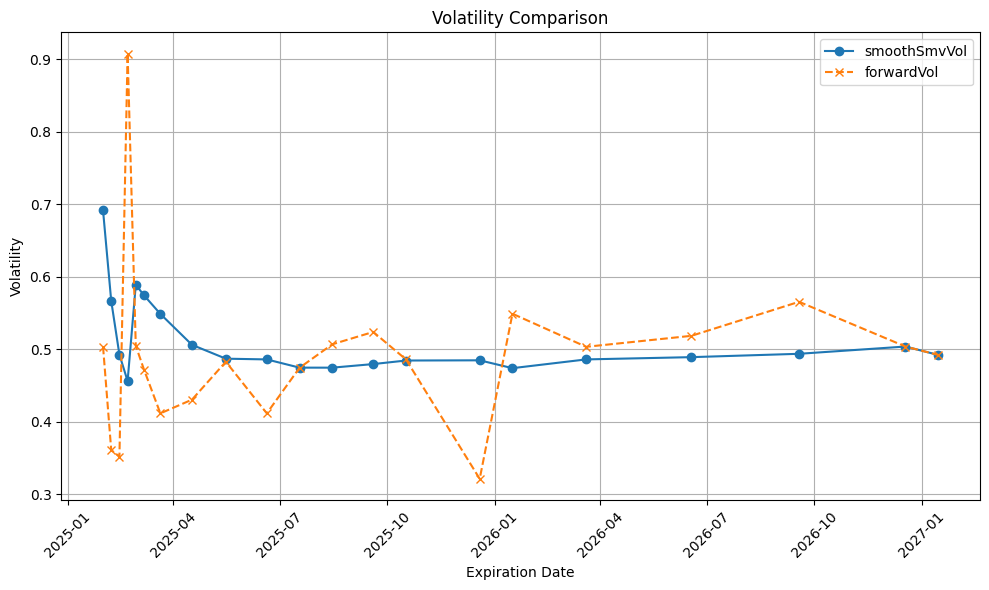

In [298]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_forward_volatility_shifted_with_expir(df, vol_col_short='smoothSmvVol', shift_period=1):
    """
    Calculates forward volatility by shifting the volatility data and the
    expiration date to create a proxy for a longer-term volatility.

    Args:
        df (pd.DataFrame): DataFrame containing option data with columns:
                           'tradeDate' (datetime or str), 'expirDate' (datetime or str),
                           'yte' (float), vol_col_short (float).
        vol_col_short (str): Name of the column containing the implied volatility
                             for a shorter maturity (which will be shifted).
                             Defaults to 'smthSmvVol'.
        shift_period (int): The number of periods (rows) to shift the volatility
                              and expiration date columns.
                              A positive value shifts down (future dates).
                              Defaults to 1.

    Returns:
        pd.DataFrame: DataFrame with added columns:
                      - '{vol_col_short}_shifted': Shifted volatility.
                      - 'shifted_expirDate': Expiration date corresponding to the shifted volatility.
                      - 'forwardVol': Calculated forward volatility.
    """
    df['tradeDate'] = pd.to_datetime(df['tradeDate'])
    df['expirDate'] = pd.to_datetime(df['expirDate'])
    df['time_to_maturity_short'] = df['yte']

    # Create the shifted volatility and expiration date columns
    shifted_vol_col_name = f'{vol_col_short}_shifted'
    df[shifted_vol_col_name] = df[vol_col_short].shift(-shift_period)
    df['shifted_expirDate'] = df['expirDate'].shift(-shift_period)

    # Calculate time to maturity for the shifted (longer-term) volatility
    df['time_to_maturity_long'] = (df['shifted_expirDate'] - df['tradeDate']).dt.days / 365.25

    # Calculate forward volatility where both long and short maturities exist
    valid_rows = ~df[shifted_vol_col_name].isna() & ~df['time_to_maturity_long'].isna()
    df['forwardVol'] = pd.NA
    df.loc[valid_rows, 'forwardVol'] = (
        (df.loc[valid_rows, 'time_to_maturity_long'] * df.loc[valid_rows, shifted_vol_col_name]**2 -
         df.loc[valid_rows, 'time_to_maturity_short'] * df.loc[valid_rows, vol_col_short]**2) /
        (df.loc[valid_rows, 'time_to_maturity_long'] - df.loc[valid_rows, 'time_to_maturity_short'])
    )**0.5

    df.drop(columns=['time_to_maturity_long', 'time_to_maturity_short'], inplace=True)
    df["forwardVol"] = df["forwardVol"].fillna(df[vol_col_short])
    return df

def plot_volatilities(df, regular_vol_col='smoothSmvVol', forward_vol_col='forwardVol', title='Volatility Comparison'):
    """
    Plots the regular volatility against the calculated forward volatility over time (expiration date).

    Args:
        df (pd.DataFrame): DataFrame containing the volatility data and expiration dates.
        regular_vol_col (str): Name of the column containing the regular volatility.
                                 Defaults to 'smthSmvVol'.
        forward_vol_col (str): Name of the column containing the calculated forward volatility.
                                 Defaults to 'forwardVol'.
        title (str): Title of the plot. Defaults to 'Volatility Comparison'.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(df['expirDate'], df[regular_vol_col], marker='o', linestyle='-', label=regular_vol_col)
    plt.plot(df['expirDate'], df[forward_vol_col], marker='x', linestyle='--', label=forward_vol_col)
    plt.xlabel('Expiration Date')
    plt.ylabel('Volatility')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

option_data_df = options_data_sample

# Calculate forward volatility by shifting 'smthSmvVol' by 1 row
option_data_df = calculate_forward_volatility_shifted_with_expir(option_data_df.copy(), shift_period=1)

# Plot the regular and forward volatilities
plot_volatilities(option_data_df)